AI/ML Engineer Role – Recruitment task


Task:

The required task is to build a classification model for the inference of customer queries into predefined categories, e.g. Customer account issues, flight changes, etc. The model should be able to accurately process each query and categorize it according to the feature query.

My Approach:

This problem can be solved with different approaches:


1.   Classical ML: Use logistic regression, random forest or SVM, this solution is elegant and simple, which makes it ideal to deploy it into production without the need of sophisticated hardware. The inference time of these models is fast, which makes it ideal for real-time customer service. Plus, it gives interpretability.
2.   Deep learning models: Pre-trained transforme models like BERT using Hugging Face's library. Powerful solution for long complex queries. Not so interpretable. The deployment of these models often require special hardwared, e.g., GPU availability.

The data looks simple enough, in the sense that is a single well structured sentence, for example: "Where can I find information on your latest discounts?". Therefore, the use of a simple logistic regression might be enough. So to continue with this, let's first do the next things:



1.   Explore the data: look at the data and check with what you are working with (pandas). This is one of the most underrated but important tasks because it can give you hints of what path to take in terms of model design and general preprocessing pipeline.
2.   Is my dataset balanced? If this is true, we can go straight to the training to train the model, however, in case this is false, some data handling must be needed or include some class weighting in the model
3.   Create a pipeline to remove punctuation, stop words and numbers. We can use a sklearn pipeline for this. A common and a nice way to do this could be using a TF-IDF score so it is more digestable for the model than raw tokenized data.
4.   Choose a model and include it in the data pipeline
5.   Split the data for validation. We could use a 20% of the data for validation.
6.   Train the model
7.   Evaluate the model
8.   Deploy the model




In [ ]:
# Install all required packages (run this first)
!pip install matplotlib seaborn pandas scikit-learn nltk joblib

In [3]:
# Import all the necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
import joblib
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re

In [4]:
# Read the csv
path = r"data\customer_queries_data.csv"
csv = pd.read_csv(path)

In [3]:
# Show the head of the csv
csv.head()

,query,label
0,I'm having trouble accessing my Ryanair custom...,Customer Account Issues
1,Can I change my flight date after booking?,Flight Changes
2,Why was my credit card payment rejected?,Payment Issues
3,How can I change the date of my flight reserva...,Flight Changes
4,What are the policies for traveling with an in...,Child and Infant Travel


In [4]:
print("Size of the dataset {}".format(len(csv)))
classes = set(csv["label"])
N_classes = len(classes)
print("Number of classes {}".format(N_classes))
print("These are the classes: {}".format(classes))

Size of the dataset 20000
Number of classes 30
These are the classes: {'Customer Account Issues', 'Seat Selection', 'COVID-19 Policies', 'Check-in Procedures', 'Partnerships and Alliances', 'Travel Restrictions', 'Weather-related Disruptions', 'Flight Bookings', 'Flight Changes', 'Promotions and Discounts', 'Business Travel', 'Travel Vouchers', 'Travel Insurance', 'Child and Infant Travel', 'Lost and Found', 'Baggage Policies', 'Travel Documentation', 'Frequent Flyer Miles', 'Payment Issues', 'Flight Status', 'Refunds and Compensation', 'Group Bookings', 'Pet Travel', 'Loyalty Programs', 'Special Assistance', 'Mobile App Issues', 'Airport Services', 'Duty-Free Shopping', 'Complaints and Feedback', 'In-flight Services'}


The data contains two things: a query, which is going to be the input of the model, and a label which is going to be the final class of the inference. The dataset has a size of 2000 queries with their respective labels and 30 classes. The first question we might have is if the dataset is balanced, e.g., it has the same amount of examples for each class. Let's inspect the actual class distribution

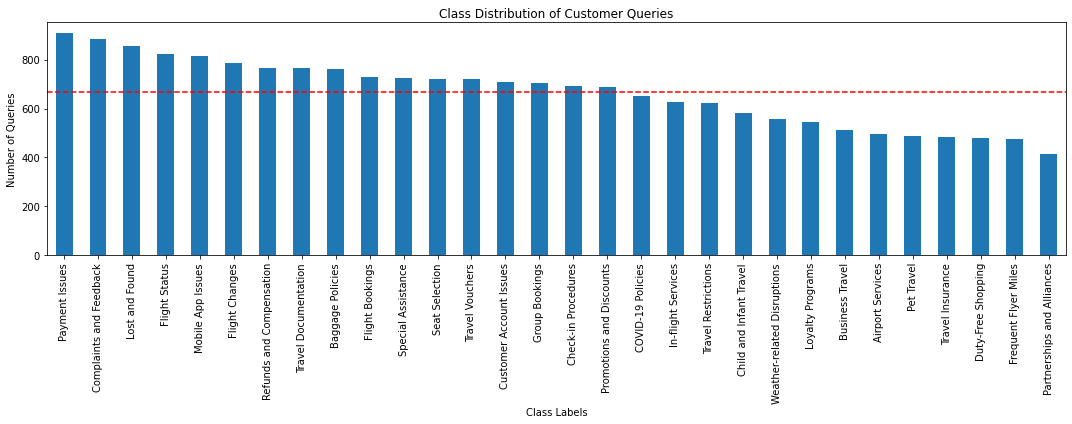

In [5]:
class_distribution = csv["label"].value_counts() # Get the value count
class_distribution.plot(kind="bar", figsize=(15, 6))
average_count = class_distribution.mean()
# We can add a dashline to see which classes are above the average, which tell us which classes are oversampled or undersampled
plt.axhline(average_count, color="red", linestyle="dashed", linewidth=1.5, label=f"Average Count: {int(average_count)}")
plt.title("Class Distribution of Customer Queries")
plt.xlabel("Class Labels")
plt.ylabel("Number of Queries")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("./media/class_distribution.jpg")
plt.show()

The data is not balanced. This means we would need to either perform a resampling (oversampling, undersampling), perform data augmentation (rephrasing works well in case data is text) or use a model with class weighting like SVMs or logistic regression. For evaluation let's use F1 so is fair the quantifying of the performance.
Another simple data visualization we could do is to analyze the query length, this could give us a hint of the data complexity we have.

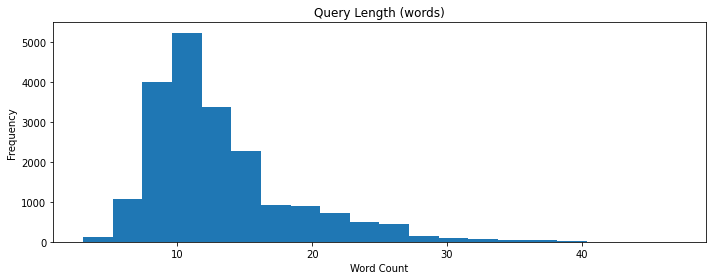

In [6]:
csv["char_len"] = csv["query"].str.len()
csv["word_len"] = csv["query"].str.split().apply(len)

# Plot
csv["word_len"].plot(kind="hist", bins=20, figsize=(10, 4), title="Query Length (words)")
plt.xlabel("Word Count")
plt.tight_layout()
plt.savefig("./media/query_length_histogram.jpg")
plt.show()

In [7]:
print("Mean lenght of characters {}".format(csv["char_len"].mean()))
print("Mean lenght of words {}".format(csv["word_len"].mean()))
print("Shortest query {}".format(csv["word_len"].min()))
print("Longest query {}".format(csv["word_len"].max()))

Mean lenght of characters 71.89085
Mean lenght of words 12.95275
Shortest query 3
Longest query 47


The queries in the dataset vary in length, both in terms of characters and words. On average, a query is about 12.95 words long and contains roughly 71.89 characters.

The shortest query in the dataset has just 3 words, while the longest query contains up to 47 words. This suggests that while most queries are concise, there are some edge cases with more detailed requests. Even though this is true, 47 word length is quite simple, so this can be the first hint we can keep a simple approach without the need of going for something more complex like deep learning solutions.

Now, let's check the word counting. This could help us understand dominant topics or concerns:

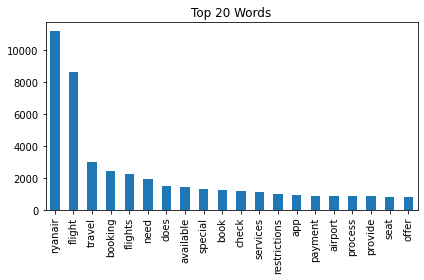

In [8]:
vectorizer = CountVectorizer(stop_words="english", max_features=20) # Remove the, is, how, can, etc...
X = vectorizer.fit_transform(csv["query"])
word_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out()).sum().sort_values(ascending=False)

# Bar chart of top words
word_freq.plot(kind="bar", title="Top 20 Words")
plt.tight_layout()
plt.savefig("./media/top_words.jpg")
plt.show()

The most frequent word across all queries was "ryanair", which is expected given the dataset's brand-specific context. Then the other words make sense, like flight, travel, booking, need, etc. This is consistent with the types of categories defined in the dataset.
Now, let's try to be more specific and check the 3 most frequent words across all classes

In [9]:
# Function to get the most frequent words per class
def top_words_per_class(label, n=10):
    subset = csv[csv["label"] == label]
    vec = CountVectorizer(stop_words="english", max_features=1000)
    X = vec.fit_transform(subset["query"])
    word_freq = pd.Series(X.sum(axis=0).A1, index=vec.get_feature_names_out()).sort_values(ascending=False)
    return word_freq.head(n)

for i in classes:
    print(i)
    print(top_words_per_class(i, n= 3))

Customer Account Issues
account    749
ryanair    489
having     277
dtype: int64
Seat Selection
seat       730
flight     438
ryanair    360
dtype: int64
COVID-19 Policies
covid      620
19         614
ryanair    450
dtype: int64
Check-in Procedures
check      646
online     402
ryanair    388
dtype: int64
Partnerships and Alliances
ryanair         394
airlines        336
partnerships    320
dtype: int64
Travel Restrictions
restrictions    612
travel          588
ryanair         251
dtype: int64
Weather-related Disruptions
weather    547
flight     524
ryanair    233
dtype: int64
Flight Bookings
flight     688
book       599
ryanair    404
dtype: int64
Flight Changes
flight     755
change     598
booking    354
dtype: int64
Promotions and Discounts
discounts    447
flights      379
ryanair      372
dtype: int64
Business Travel
business     558
ryanair      400
travelers    359
dtype: int64
Travel Vouchers
travel     720
voucher    579
use        434
dtype: int64
Travel Insurance
insur

Now, while the keywords extracted are informative, their ubiquity may limit their discriminative power for classification. Therefore, this could tell us that using TF-IDF weighting might be useful because it downweights frequently occurring words across all classes (such as "ryanair" or "flight") and emphasizes words that are more unique or specific to a particular class (like "voucher", "complaint", or "miles"). This helps the model focus on the most relevant signals for classification rather than common terms that appear in nearly every query.
The next question in terms of data exploration is if there is any duplicate or empty query that might harm the model's performance

In [10]:
print("Duplicate queries:", csv.duplicated(subset="query").sum())
print("Empty queries:", (csv["query"].str.strip() == '').sum())

Duplicate queries: 32
Empty queries: 0


The presence of 32 duplicate queries in a dataset of 20,000 examples is minimal (0.16%) and unlikely to impact model performance significantly. However we can remove them easily with the next command

In [5]:
print("Before removal:", csv.shape)
# Drop duplicates
csv = csv.drop_duplicates(subset="query", keep="first")
print("After removal:", csv.shape)

Before removal: (20000, 2)
After removal: (19968, 2)


To explore whether there is a relationship between query length and category, which could reveal whether certain types of requests tend to require more detailed explanations

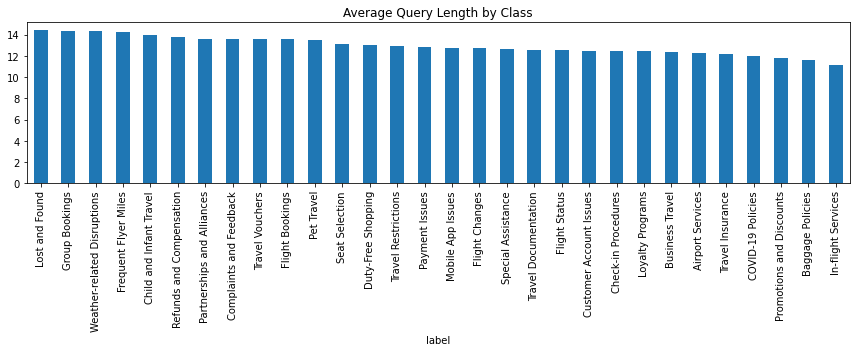

In [12]:
avg_len = csv.groupby("label")["word_len"].mean().sort_values(ascending=False)
avg_len.plot(kind="bar", title="Average Query Length by Class", figsize=(12, 5))
plt.tight_layout()
plt.savefig("./media/avg_query_length_per_class.jpg")
plt.show()

Indeed there is a difference between the classes and query length, however there is a lot of overlapping in between classes, so a simple classifier using only this parameter would not be enough.

With all the information above is clear that a deep learning approach would overkill this task. Therefore, let's keep it simple with a logistic regression model. We can create a pipeline with *TfidfVectorizer* which will be the preprocessing of the data before performing the inference. Since we have an unbalance dataset let's add class weightining in the model so it automatically adjust the weights proportionally to class frequency.

In case you already have the models trained and ready, you can load the encoder and model you can simply load the model and encoder and jump straight into the inference.

In [13]:
pipeline = joblib.load("saved_models\LR_model.joblib")
label_encoder = joblib.load("saved_models\LR_label_encoder.joblib")

If the training is from scratch, we can create our pipeline

In [7]:
# Create pipeline with class_weight='balanced' for unbalanced data
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", random_state = 42))
])

Now lets encode the labels and split the data. Label encoding is important so we only deal with numbers, no text.

A good rule of thumb for splitting the data is 20% (in this case we would have 4000 inputs to validate our model), so we have enough data we can evaluate our model and check the performance. We can use train_test_split function sklearn.

In [8]:
# Encode labels
le = LabelEncoder()
csv["label_encoded"] = le.fit_transform(csv["label"])

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    csv["query"], csv["label_encoded"], test_size=0.2, random_state=42, stratify=csv["label_encoded"]
)

Once this is done, we just need to train the model. Use the fit function to train the entire pipeline. Remember that for each batch, first we will perform a preprocessing with the function TfidfVectorizer and then go to our logisti regression model to perform the inference

In [9]:
#Train the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

Once the model is trained, we can simply predict the test data we splitted before (X_test,y_test). Remember that the model will produce the classes in the encoded numbers we used to train the network. We can inverse_transforme those to see which classes are getting a good precision and which ones not. Also a classification_report is very useful to directly check the f1-scores (trade-off of precision and recall) for each class. We see that the accuracy we get is about 99% which tells us the model is performing quite well.

In [10]:
y_pred = pipeline.predict(X_test)

# Inverse transform for readable labels
target_names = le.inverse_transform(sorted(set(y_test)))

# Print report
print(classification_report(y_test, y_pred, target_names=target_names))

                             precision    recall  f1-score   support

           Airport Services       0.99      0.97      0.98        99
           Baggage Policies       1.00      1.00      1.00       152
            Business Travel       1.00      1.00      1.00       102
          COVID-19 Policies       0.96      0.94      0.95       130
        Check-in Procedures       0.99      0.98      0.99       139
    Child and Infant Travel       0.98      0.99      0.99       116
    Complaints and Feedback       1.00      1.00      1.00       177
    Customer Account Issues       0.99      0.99      0.99       142
         Duty-Free Shopping       1.00      1.00      1.00        96
            Flight Bookings       0.97      0.96      0.97       145
             Flight Changes       0.99      0.98      0.98       156
              Flight Status       0.98      1.00      0.99       164
       Frequent Flyer Miles       1.00      0.98      0.99        94
             Group Bookings      

An easy way to check this is using a confusion matrix, which tells you exactly how your model is performing across different classes, not just overall. The rows are the (true) classes and the columns are the predictions. This means that the correct prediction is the diagonal of the matrix, so the further off-diagonal a cell is populated, it means the model is struggling dealing with that class.

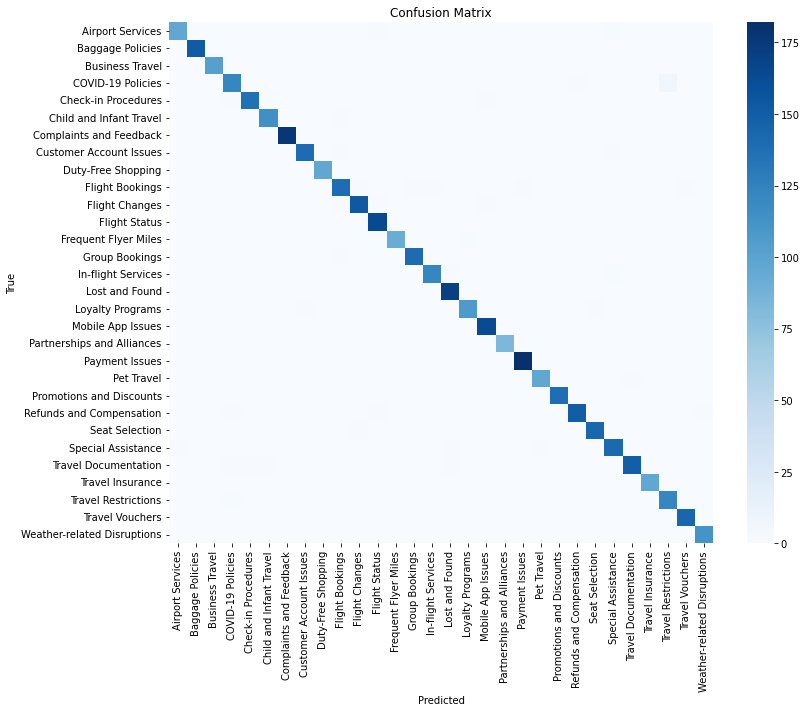

In [18]:
# Plot a confusion matrix for an easy check of the performance
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, xticklabels=target_names, yticklabels=target_names, annot=False, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("./media/confusion_matrix.jpg")
plt.show()

The model looks very accurate, so now is time to predict on the test dataset. First let's read the csv with the testing dataset

In [11]:
# Read the test dataset
path = r"data\customer_queries_test.csv"
csv_test = pd.read_csv(path)

In this case, only query data is available, the model will be the one which generates the labels

In [12]:
# Check what data we actually have in the file
csv_test.head()

,query
0,Am I able to choose my seat during the flight ...
1,Am I eligible for a refund if my flight is can...
2,Any current travel restrictions?
3,App crashes on startup. Help!
4,Are animals allowed on Ryanair flights?


Now, let's use the trained pipeline we have to generate the new labels. Remember the inferences are going to be encoded, so we would need to invert the encoding of these labels.

In [21]:
# Use the pipeline to predict the labels on unseen data
test_predictions_encoded = pipeline.predict(csv_test['query'])
# The data is encoded, so let's use the inverse_transform function to decoded
test_predictions = le.inverse_transform(test_predictions_encoded)
# So now let's create a dataframe with the queries and labels
csv_test['labels'] = test_predictions
csv_test.head()

,query,labels
0,Am I able to choose my seat during the flight ...,Seat Selection
1,Am I eligible for a refund if my flight is can...,Refunds and Compensation
2,Any current travel restrictions?,Travel Restrictions
3,App crashes on startup. Help!,Mobile App Issues
4,Are animals allowed on Ryanair flights?,Pet Travel


Now that we have the complete data, we can simply save the csv

In [22]:
# Save the new csv
csv_test.to_csv("data\customer_queries_test_with_predictions.csv", index=False)

Now we only need to save our model and our encoder

In [23]:
# Save the models and the label encoder using the dump function
joblib.dump(pipeline, "saved_models\LR_model.joblib")
joblib.dump(le, "saved_models\LR_label_encoder.joblib")

['saved_models\\LR_label_encoder.joblib']

Logistic regression is inherently interpretable, which is one of its strengths. We can extract feature importance per class directly from the model to understand which words influence classification. 

In [13]:
vectorizer = pipeline.named_steps['tfidf'] # Here we get the tfid
classifier = pipeline.named_steps['clf'] # Here we get the logisticRegression
feature_names = vectorizer.get_feature_names_out() # Then the feature names from the vectorizer

In [14]:
def show_top_features(class_index, top_n=10):
    class_label = classifier.classes_[class_index]
    coef = classifier.coef_[class_index]
    top_indices = np.argsort(coef)[-top_n:]
    # Print the actual name of the class, not the encoded
    try:
        print(f"Top features for class: {le.inverse_transform([class_label])[0]}")
    except:
        print(f"Top features for class: {label_encoder.inverse_transform([class_label])[0]}")
    for i in reversed(top_indices):
        print(f"{feature_names[i]:<20} -> {coef[i]:.4f}")
show_top_features(class_index=3) 

Top features for class: COVID-19 Policies
covid                -> 7.4058
19                   -> 6.9801
policies             -> 3.4596
mask                 -> 3.2747
quarantine           -> 3.2297
measures             -> 2.0341
requirements         -> 2.0163
safety               -> 1.9239
test                 -> 1.7398
wear                 -> 1.5600


This interpretability study, although is simple, it explains which words are pushing the model towards each class. We can make plot of each class to understand it easier:

Top features for class: Child and Infant Travel


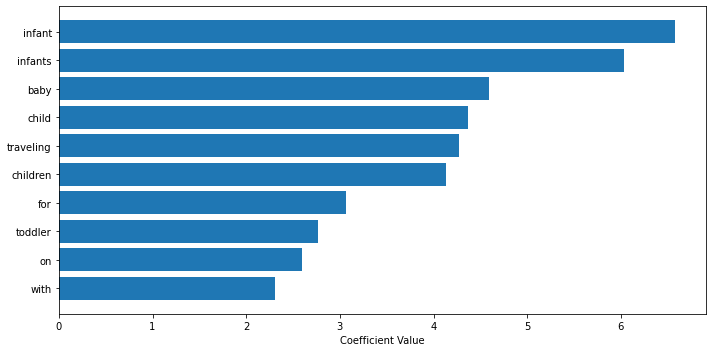

In [26]:
# Here we make a function to plot the index class we are trying to study
def plot_top_features(class_index, top_n=10):
    # Select the class
    class_label = classifier.classes_[class_index]
    # Get the coefficients of that class
    coef = classifier.coef_[class_index]
    # We can sort the coeffitients to get the top indices
    top_indices = np.argsort(coef)[-top_n:]
    top_words = feature_names[top_indices]
    top_values = coef[top_indices]
    # Plot the result
    plt.figure(figsize=(10, 5))
    plt.barh(top_words, top_values)
    # Use the try and except case just to ensure you have loaded the label encoder
    try:
        print(f"Top features for class: {le.inverse_transform([class_label])[0]}")
    except:
        plt.title(f"Top {top_n} Features for Class: {label_encoder.inverse_transform([class_label])[0]}")
    plt.xlabel("Coefficient Value")
    plt.tight_layout()
    plt.show()
plot_top_features(5)

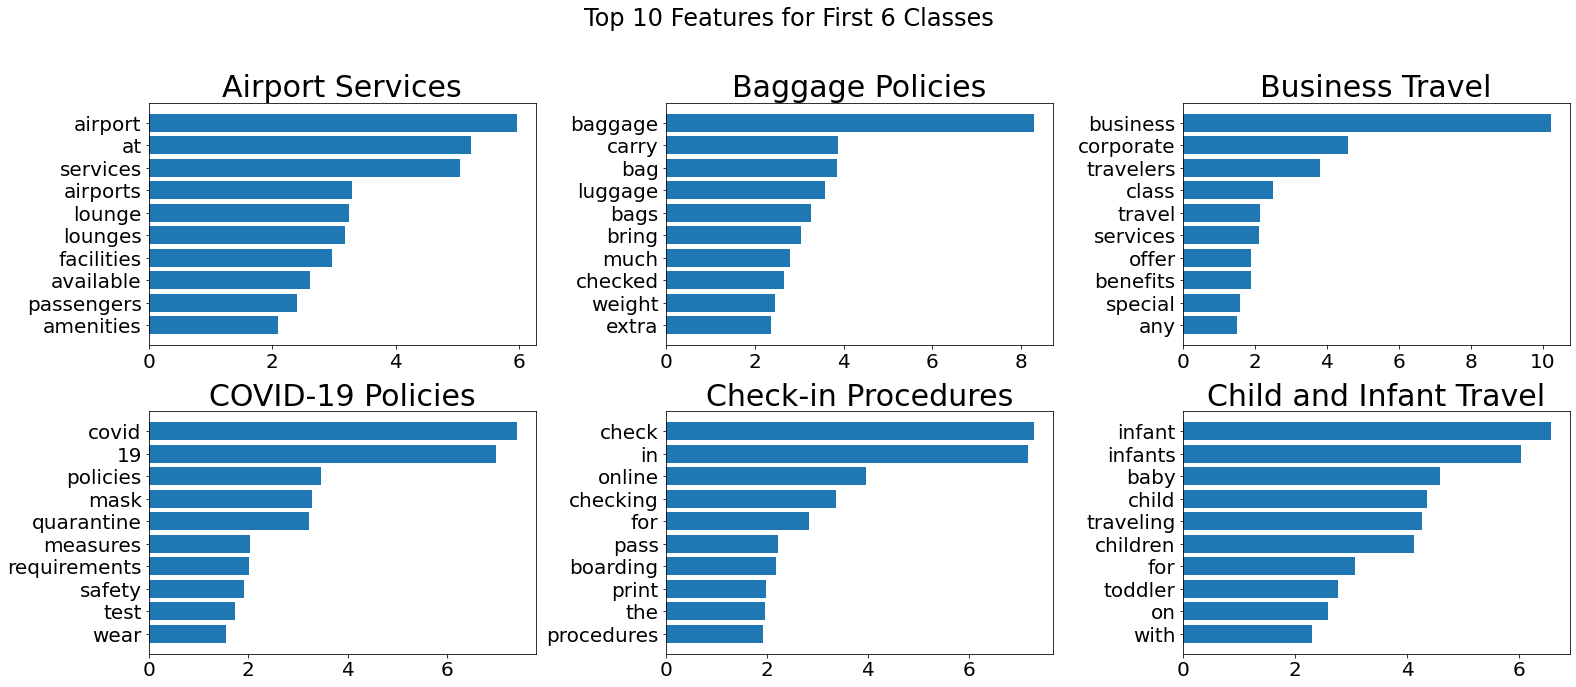

In [27]:
# Plot top features for the first 6 classes
fig, axes = plt.subplots(2, 3, figsize=(22, 10))
fig.suptitle("Top 10 Features for First 6 Classes", fontsize=24)

for idx in range(6):
    ax = axes[idx // 3, idx % 3]
    class_label = classifier.classes_[idx]
    coef = classifier.coef_[idx]
    top_indices = np.argsort(coef)[-10:]
    top_words = feature_names[top_indices]
    top_values = coef[top_indices]

    ax.barh(top_words, top_values)
    try:
        ax.set_title(f"{le.inverse_transform([class_label])[0]}", fontsize=30)
    except:
        ax.set_title(f"{label_encoder.inverse_transform([class_label])[0]}", fontsize=30)
    #ax.set_xlabel("Coefficient Value", fontsize=14)
    ax.tick_params(labelsize=20)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("./media/Features_classes.jpg")
plt.show()

So far we used a very simple approach where almost no preprocessing is being used. However, we can see that in the top 10 first features the model focuses on both plural and singular forms of the same word, for example, "airport" and "airports". Although the model already achieves a performance of 0.99, we can try to improve generalization and reduce feature redundancy by applying lemmatization, which normalizes words to their base form. This may not significantly change the performance on the current dataset, but it could make the model more robust to unseen variations and reduce noise in the feature space, especially if the dataset is expanded in the future. Here we will implement lemmatization to try to make the model more robust and reduce the feature redundancy

In [15]:
# Download required NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def lemmatize_text(text):
    # Basic cleanup
    text = re.sub(r'[^\w\s]', '', text.lower())
    tokens = nltk.word_tokenize(text)
    lemmatized = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(lemmatized)
# Add a new column with the database processed
csv["query_lemmatized"] = csv["query"].apply(lemmatize_text)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\NMSBDeep\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\NMSBDeep\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\NMSBDeep\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We will follow the same procedure as before but now with the processed data

In [16]:
# Encode labels
le = LabelEncoder()
csv["label_encoded"] = le.fit_transform(csv["label"])

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    csv["query_lemmatized"], csv["label_encoded"], test_size=0.2, random_state=42, stratify=csv["label_encoded"]
)

                             precision    recall  f1-score   support

           Airport Services       0.98      0.98      0.98        99
           Baggage Policies       0.98      1.00      0.99       152
            Business Travel       1.00      1.00      1.00       102
          COVID-19 Policies       0.98      0.92      0.95       130
        Check-in Procedures       0.99      0.96      0.97       139
    Child and Infant Travel       0.97      0.98      0.98       116
    Complaints and Feedback       1.00      0.99      1.00       177
    Customer Account Issues       0.99      0.99      0.99       142
         Duty-Free Shopping       1.00      1.00      1.00        96
            Flight Bookings       0.96      0.95      0.96       145
             Flight Changes       0.99      0.97      0.98       156
              Flight Status       0.98      1.00      0.99       164
       Frequent Flyer Miles       0.99      0.98      0.98        94
             Group Bookings      

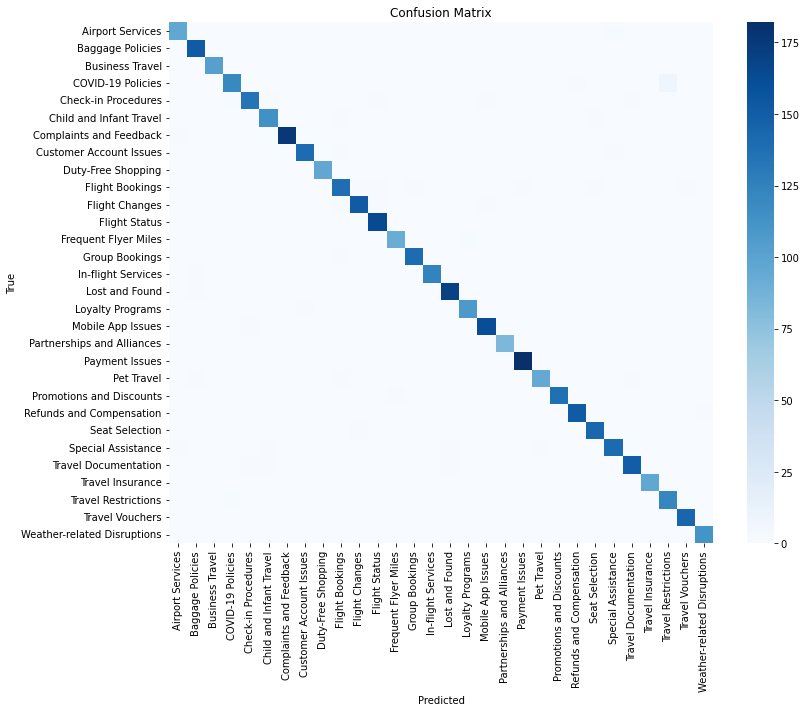

In [17]:
# Create pipeline with class_weight='balanced' for unbalanced data
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", random_state = 42))
])

#Train the model
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Inverse transform for readable labels
target_names = le.inverse_transform(sorted(set(y_test)))

# Print report
print(classification_report(y_test, y_pred, target_names=target_names))

# Plot a confusion matrix for an easy check of the performance
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, xticklabels=target_names, yticklabels=target_names, annot=False, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("./media/confusion_matrix_lemmatized.jpg")
plt.show()

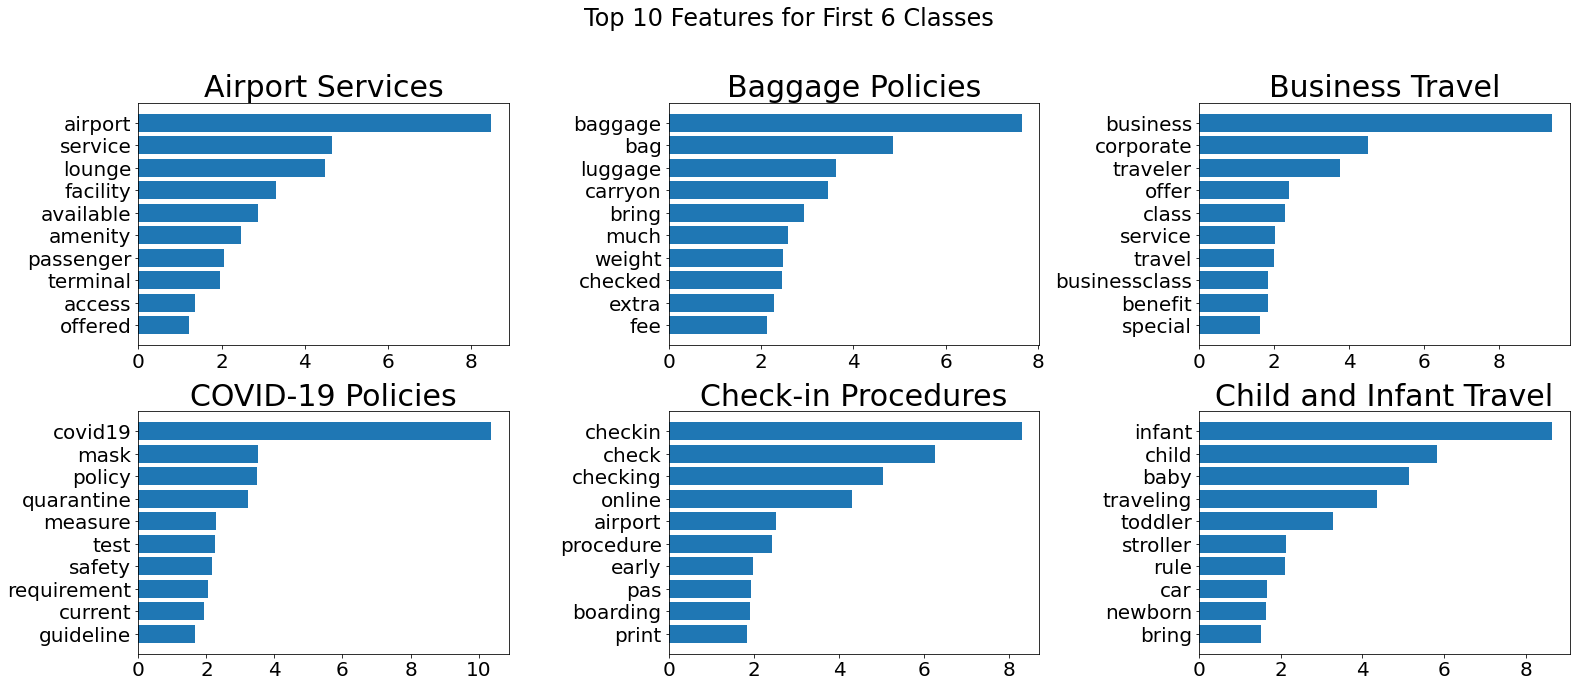

In [18]:
vectorizer = pipeline.named_steps['tfidf'] # Here we get the tfid
classifier = pipeline.named_steps['clf'] # Here we get the logisticRegression
feature_names = vectorizer.get_feature_names_out() # Then the feature names from the vectorizer

# Here we make a function to plot the index class we are trying to study
def plot_top_features(class_index, top_n=10):
    # Select the class
    class_label = classifier.classes_[class_index]
    # Get the coefficients of that class
    coef = classifier.coef_[class_index]
    # We can sort the coeffitients to get the top indices
    top_indices = np.argsort(coef)[-top_n:]
    top_words = feature_names[top_indices]
    top_values = coef[top_indices]
    # Plot the result
    plt.figure(figsize=(10, 5))
    plt.barh(top_words, top_values)
    try:
        plt.title(f"Top {top_n} Features for Class: {label_encoder.inverse_transform([class_label])[0]}")
    except:
        plt.title(f"Top {top_n} Features for Class: {le.inverse_transform([class_label])[0]}")
    plt.xlabel("Coefficient Value")
    plt.tight_layout()
    plt.show()
    
# Plot top features for the first 6 classes
fig, axes = plt.subplots(2, 3, figsize=(22, 10))
fig.suptitle("Top 10 Features for First 6 Classes", fontsize=24)

for idx in range(6):
    ax = axes[idx // 3, idx % 3]
    class_label = classifier.classes_[idx]
    coef = classifier.coef_[idx]
    top_indices = np.argsort(coef)[-10:]
    top_words = feature_names[top_indices]
    top_values = coef[top_indices]

    ax.barh(top_words, top_values)
    try:
        ax.set_title(f"{label_encoder.inverse_transform([class_label])[0]}", fontsize=30)
    except:
        ax.set_title(f"{le.inverse_transform([class_label])[0]}", fontsize=30)
    #ax.set_xlabel("Coefficient Value", fontsize=14)
    ax.tick_params(labelsize=20)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("./media/Features_classes_lemmatized.jpg")
plt.show()

As shown above, lemmatization does not significantly alter model performance in this dataset, likely because the TF-IDF + logistic regression pipeline already generalizes well. However, it offers a cleaner, more compact feature space, which could become more beneficial as the dataset scales or becomes more linguistically diverse. It also aligns better with best practices in NLP preprocessing for long-term maintainability and interpretability.

In [32]:
# Save the models and the label encoder using the dump function
joblib.dump(pipeline, "saved_models\LR_model_lemmatized.joblib")
joblib.dump(le, "saved_models\LR_label_encoder_lemmatized.joblib")

['saved_models\\LR_label_encoder_lemmatized.joblib']

During the data exploration stage we saw that the word "Ryanair" is the most repeated word in the queries. This is normal due to the branding dataset, however this doesn't add a lot of information regarding the classes. Therefore, let's make a third model variation where we remove this word. We can use a custom stop word with an union and add it to our pipeline. **Please make sure to run the previous cells, so this part of the code can run without errors**

In [20]:
custom_stop_words = ENGLISH_STOP_WORDS.union({"ryanair"})

# Create pipeline with class_weight='balanced' for unbalanced data
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words = custom_stop_words)),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", random_state = 42))
])

#Train the model
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Inverse transform for readable labels
target_names = le.inverse_transform(sorted(set(y_test)))

# Print report
print(classification_report(y_test, y_pred, target_names=target_names))

                             precision    recall  f1-score   support

           Airport Services       0.99      0.99      0.99        99
           Baggage Policies       0.97      1.00      0.99       152
            Business Travel       1.00      1.00      1.00       102
          COVID-19 Policies       0.96      0.92      0.94       130
        Check-in Procedures       0.99      0.96      0.97       139
    Child and Infant Travel       0.97      0.98      0.98       116
    Complaints and Feedback       1.00      0.99      0.99       177
    Customer Account Issues       0.99      0.99      0.99       142
         Duty-Free Shopping       1.00      1.00      1.00        96
            Flight Bookings       0.95      0.95      0.95       145
             Flight Changes       0.99      0.97      0.98       156
              Flight Status       0.98      1.00      0.99       164
       Frequent Flyer Miles       0.99      0.98      0.98        94
             Group Bookings      

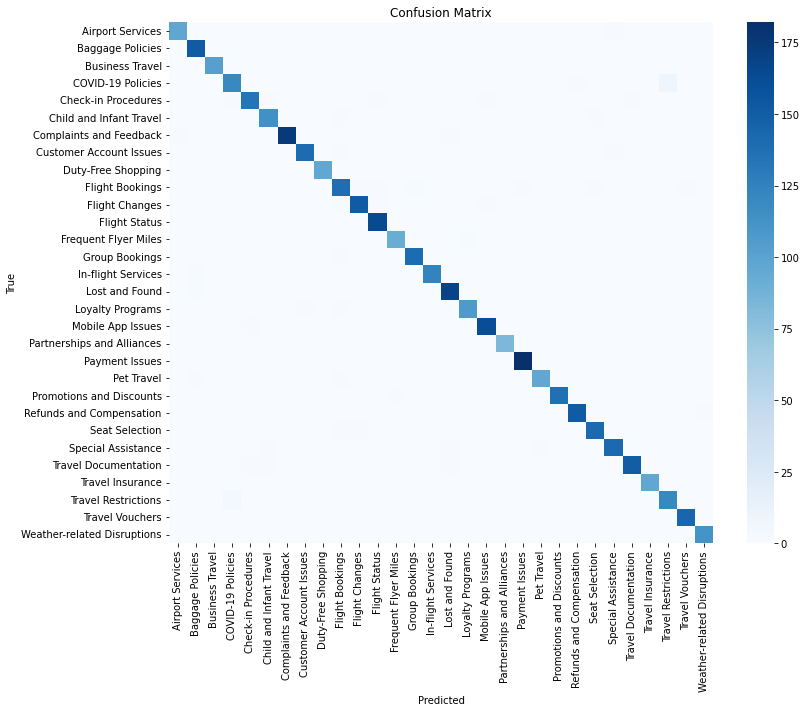

In [21]:
# Plot a confusion matrix for an easy check of the performance
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, xticklabels=target_names, yticklabels=target_names, annot=False, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("./media/confusion_matrix_lemmatized_removeRyanair.jpg")
plt.show()

The model shows a slight improvement with the lemmatized model in terms of macro and weighted average F1-score. So, the removal of “Ryanair” helped reduce noise in the feature space and improved the clarity of top model features without any negative impact on performance. 

In [7]:
# Save the models and the label encoder using the dump function
joblib.dump(pipeline, "saved_models\LR_model_lemmatized_removeRyanair.joblib")
joblib.dump(le, "saved_models\LR_label_encoder_lemmatized_removeRyanair.joblib")

['saved_models\\LR_label_encoder_lemmatized_removeRyanair.joblib']

Now it would be great if we could add some interpretability by getting the probabilities of any query. For this we could simply use the command pipeline.predict_proba(x) and then perform the transformation of the labels (same as we have done it so far)

In [35]:
# Function to lemmatize and remove ryanair words
def lemmatize_text(text):
    text = re.sub(r'[^\w\s]', '', text.lower())
    tokens = nltk.word_tokenize(text)
    lemmatized = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in stop_words and word != "ryanair"
    ]
    return ' '.join(lemmatized)
# Query
query = "Am I able to choose my seat during the flight booking process, and are there any additional fees for certain seats?"
processed_query = lemmatize_text(query)
print("This is the processed query:  {}".format(processed_query))

This is the processed query:  able choose seat flight booking process additional fee certain seat


Now that the query has been processed, then we can obtain the probabilities of the inference

In [36]:
probas = pipeline.predict_proba([processed_query])
# Get class labels
class_names = le.inverse_transform(np.arange(len(pipeline.classes_)))
#There is a single query in this example
sample_index = 0

# Get the top 5 predicted probabilities for that sample
proba_series = pd.Series(probas[sample_index], index=class_names)
top_probs = proba_series.sort_values(ascending=False).head(5)

We can plot it so its easy to check what class refers to

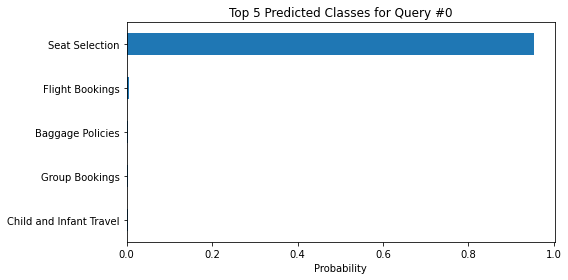

In [39]:
# Plot
plt.figure(figsize=(8, 4))
top_probs.plot(kind="barh")
plt.gca().invert_yaxis()  # Highest prob at top
plt.title(f"Top 5 Predicted Classes for Query #{sample_index}")
plt.xlabel("Probability")
plt.tight_layout()
plt.savefig("./media/prob_seat_selection.jpg")
plt.show()

Let's try on query where the confidence is not that high due to the feature selection. For example: "Are masks required on all Ryanair flights?"

This is the processed query:  mask required flight


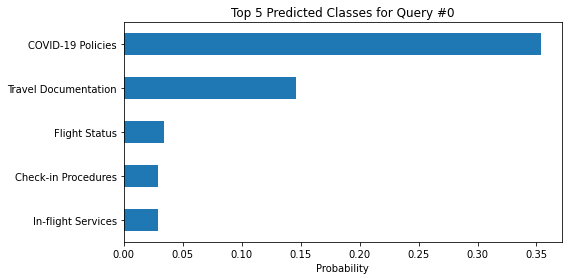

In [40]:
query = "Are masks required on all Ryanair flights?"
processed_query = lemmatize_text(query)
print("This is the processed query:  {}".format(processed_query))
probas = pipeline.predict_proba([processed_query])
sample_index = 0
proba_series = pd.Series(probas[sample_index], index=class_names)
top_probs = proba_series.sort_values(ascending=False).head(5)
plt.figure(figsize=(8, 4))
top_probs.plot(kind="barh")
plt.gca().invert_yaxis()  # Highest prob at top
plt.title(f"Top 5 Predicted Classes for Query #{sample_index}")
plt.xlabel("Probability")
plt.tight_layout()
plt.savefig("./media/prob_covid19.jpg")
plt.show()